In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Connect notebook to desired path
# Change dir_path to the new location of this notebook
import os
import sys
dir_path = '/content/gdrive/My Drive/CS 5804/Mini-Project'
sys.path.append(dir_path)

In [ ]:
# Install required modules
!pip install numpy pandas matplotlib seaborn torch torchvision transformers datasets

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision as thv
from PIL import Image

In [ ]:
# Set seed for reproducability
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
# Load dataset
# Ensure dataset are in a folder called birds in same location as notebook
data_df = pd.read_csv(f"{dir_path}/birds/birds.csv")
data_df


,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
62383,399,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
62384,399,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
62385,399,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
62386,399,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [ ]:
# Separate dataset into train, test, and validation dataframes
train_df = data_df[data_df['data set'] == 'train']
test_df = data_df[data_df['data set'] == 'test']
valid_df = data_df[data_df['data set'] == 'valid']

train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)

print(len(train_df))
print(len(test_df))
print(len(valid_df))
train_df

58388
2000
2000


,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
58383,399,train/YELLOW HEADED BLACKBIRD/155.jpg,YELLOW HEADED BLACKBIRD,train
58384,399,train/YELLOW HEADED BLACKBIRD/156.jpg,YELLOW HEADED BLACKBIRD,train
58385,399,train/YELLOW HEADED BLACKBIRD/157.jpg,YELLOW HEADED BLACKBIRD,train
58386,399,train/YELLOW HEADED BLACKBIRD/158.jpg,YELLOW HEADED BLACKBIRD,train


In [ ]:
# Create dictionary to one hot encode labels
labels = train_df['labels'].unique()
labels_dict = dict()
for i in range(len(labels)):
  labels_dict[labels[i]] = i

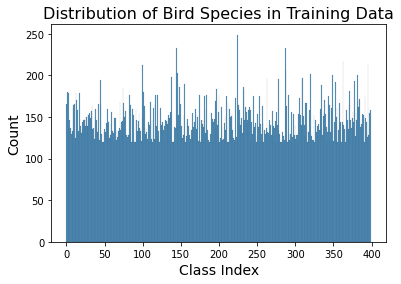

In [ ]:
# Plot distribution of training data
sns.color_palette("tab10")
distribution = sns.histplot(data = train_df, x = "class index", bins = 400)
distribution.set_title('Distribution of Bird Species in Training Data', fontsize = 16)
distribution.set_xlabel('Class Index', fontsize = 14)
distribution.set_ylabel('Count', fontsize = 14)
plt.show()

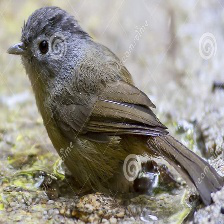

In [ ]:
test_img = Image.open(f"{dir_path}/birds/{train_df['filepaths'][0]}")
test_img

In [ ]:
from datasets import Dataset

# Create Class to convert dataframe into Dataset
class BirdsDataset(Dataset):
  def __init__(self, images, labels, num_classes, dir_path, feature_extractor):
    self.images = images
    self.labels = labels
    self.num_classes = num_classes
    self.dir_path = dir_path
    self.feature_extractor = feature_extractor

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(f"{self.dir_path}/birds/{self.images[idx]}")
    img_tensor = self.feature_extractor(images = img, return_tensors = "pt")
    #transforms = thv.transforms.ToTensor()
    #img_tensor = transforms(img)

    labels = np.zeros(self.num_classes)
    labels[self.labels[idx]] = 1
    labels_tensor = torch.tensor(labels, dtype = torch.long)
    return img_tensor, labels_tensor

In [ ]:
from transformers import ViTFeatureExtractor
from torch.utils.data import RandomSampler, DataLoader

# If there is a GPU available use it
if torch.cuda.is_available():       
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Convert DataFrames into Datasets
train_dataset = BirdsDataset(train_df['filepaths'], 
                             train_df['class index'], 
                             len(labels_dict), 
                             dir_path, 
                             feature_extractor)
test_dataset = BirdsDataset(test_df['filepaths'], 
                            test_df['class index'], 
                            len(labels_dict), 
                            dir_path, 
                            feature_extractor)
valid_dataset = BirdsDataset(valid_df['filepaths'], 
                             valid_df['class index'], 
                             len(labels_dict), 
                             dir_path, 
                             feature_extractor)

# Create Random Samplers for the data loaders
train_random_sampler = RandomSampler(train_dataset)
test_random_sampler = RandomSampler(test_dataset)
valid_random_sampler = RandomSampler(valid_dataset)

batch_size = 64

# Create Dataloaders for the datasets
train_dl = DataLoader(dataset = train_dataset,
                      batch_size = batch_size,
                      sampler = train_random_sampler)
test_dl = DataLoader(dataset = test_dataset,
                     batch_size = batch_size,
                     sampler = test_random_sampler)
valid_dl = DataLoader(dataset = valid_dataset,
                      batch_size = batch_size,
                      sampler = valid_random_sampler)

In [ ]:
import torch.nn as nn
from transformers import ViTModel

# Create binary classification layer for ViT model
class BirdClassifier(nn.Module):
  def __init__(self):
    super(BirdClassifier, self).__init__()

    D_in, H, D_out = 768, 500, 400

    self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

    self.classifer = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Dropout(0.2), 
        nn.Linear(H, D_out)
    )

  def forward(self, x):

    outputs = self.vit(x)

    last_hidden_state_cls = outputs[0][:, 0, :]

    logits = self.classifer(last_hidden_state_cls)

    return F.softmax(logits, dim = 1)

In [ ]:
# Initialize the model, optimizer, scheduler, and loss function
from transformers import AdamW, get_linear_schedule_with_warmup

epochs = 6
learning_rate = 1e-5

model = BirdClassifier()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

total_steps = len(train_dl) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss()
loss_fn.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BCELoss()

In [ ]:
print(len(train_dl))

913


In [ ]:
import random
import time

# Train the model
print("Start training...\n")
# Initialize list of losses
train_losses = list()
val_losses = list()

for epoch_i in range(epochs):
  # Print result table
  print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^9} | {'Val Acc':^9} | {'Elapsed':^9}")
  print("-"*70)

  t0_epoch, t0_batch = time.time(), time.time()

  total_loss, batch_loss, batch_counts = 0, 0, 0

  model.train()

  # Go through each batch of training data
  for step, batch in enumerate(train_dl):
    batch_counts +=1
    
    b_images, b_labels = batch
    curr_batch_size = b_images['pixel_values'].shape[0]
    b_images = b_images['pixel_values'].reshape((curr_batch_size, 3, 224, 224))
    b_images, b_labels = b_images.to(device), b_labels.to(device)

    output = model(b_images)
    loss = loss_fn(output, b_labels.float())
    batch_loss += loss.item()
    total_loss += loss.item()

    # Adjust weights through backpropagation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Print the loss values and time elapsed for every 100 batches
    if (step % 100 == 0 and step != 0) or (step == len(train_dl) - 1):
      time_elapsed = time.time() - t0_batch

      print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^9} | {'-':^9} | {time_elapsed:^9.2f}")

      batch_loss, batch_counts = 0, 0
      t0_batch = time.time()

  # Calculate the average loss
  avg_train_loss = total_loss / len(train_dl)
  train_losses.append(avg_train_loss)

  print("-"*70)

  # Obtain accuracy after each epoch
  model.eval()

  val_accuracy = []
  val_loss = []

  # Go through each batch of valid data
  for batch in valid_dl:
    b_images, b_labels = batch
    curr_batch_size = b_images['pixel_values'].shape[0]
    b_images = b_images['pixel_values'].reshape((curr_batch_size, 3, 224, 224))
    b_images, b_labels = b_images.to(device), b_labels.to(device)

    with torch.no_grad():
      output = model(b_images)

      loss = loss_fn(output, b_labels.float())
      val_loss.append(loss.item())

      preds = torch.argmax(output, dim = 1)

      truth = torch.argmax(b_labels, dim = 1)

      accuracy = (preds == truth).cpu().numpy().mean() * 100
      val_accuracy.append(accuracy)

  # Compute the average accuracy and loss over the validation set.
  val_loss = np.mean(val_loss)
  val_losses.append(val_loss)
  val_accuracy = np.mean(val_accuracy)

  time_elapsed = time.time() - t0_epoch
  
  print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^9.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
  print("-"*70)
  print("\n")

print("Training complete!")

Start training...

 Epoch  |  Batch  |  Train Loss  | Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.017364   |     -     |     -     |  220.06  
   1    |   200   |   0.016958   |     -     |     -     |  224.56  
   1    |   300   |   0.016510   |     -     |     -     |  225.72  
   1    |   400   |   0.015992   |     -     |     -     |  225.43  
   1    |   500   |   0.015439   |     -     |     -     |  225.71  
   1    |   600   |   0.014816   |     -     |     -     |  225.45  
   1    |   700   |   0.014227   |     -     |     -     |  225.19  
   1    |   800   |   0.013623   |     -     |     -     |  225.25  
   1    |   900   |   0.012993   |     -     |     -     |  225.31  
   1    |   912   |   0.012591   |     -     |     -     |   25.49  
----------------------------------------------------------------------
   1    |    -    |   0.015291   | 0.012404  |   77.78   |  2078.48 
-----------

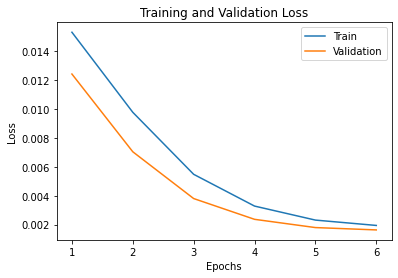

In [ ]:
plt.plot(range(1, epochs + 1), train_losses, label = 'Train')
plt.plot(range(1, epochs + 1), val_losses, label = "Validation")
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
# Gets the output from the model
def get_predictions(model, data_loader):
  model = model.eval()

  predictions = []
  targets = []

  with torch.no_grad():
    for batch in data_loader:
      b_images, b_labels = batch
      curr_batch_size = b_images['pixel_values'].shape[0]
      b_images = b_images['pixel_values'].reshape((curr_batch_size, 3, 224, 224))
      b_images, b_labels = b_images.to(device), b_labels.to(device)

      output = model(b_images)

      preds = torch.argmax(output, dim = 1)
      truth = torch.argmax(b_labels, dim = 1)

      predictions.extend(preds)
      targets.extend(truth)

  predictions = torch.stack(predictions).cpu()
  targets = torch.stack(targets).cpu()
  return predictions, targets

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Obtain Confusion Matrix for Test dataset
model_pred, truth = get_predictions(model, test_dl)
print(classification_report(truth, model_pred, zero_division = 0, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    0.8000    0.8889         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    1.0000         5
          14     1.0000    1.0000    1.0000         5
          15     1.0000    1.0000    1.0000         5
          16     1.0000    1.0000    1.0000         5
          17     1.0000    